In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from pandas.plotting import table 
from datetime import datetime

from tensorflow.keras.optimizers import SGD, Adam

In [2]:
import tensorflow as tf
print('tensorflow' + tf.__version__)
import tensorboard as tensorboard
print('tensorboard' + tensorboard.__version__)
import seaborn as seaborn
print('seaborn' + seaborn.__version__)
tf.config.list_physical_devices('GPU') 
tf.test.is_built_with_cuda
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

tensorflow2.1.0
tensorboard2.1.1
seaborn0.10.1
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4750682762887066586,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6586313605
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3877958351210373464
 physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3a:00.0, compute capability: 7.5"]

# Helper methods

In [4]:
def save(path):
    plt.savefig('../../images' + path)
    return

def loadDataSet():
#     df  = pd.read_csv("../input/stroke-dataset/stroke_subset.csv")
    return pd.read_csv("../input/stroke-dataset/stroke.csv")

In [5]:
df=loadDataSet();
df = df.drop('id',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


# Data Exploration

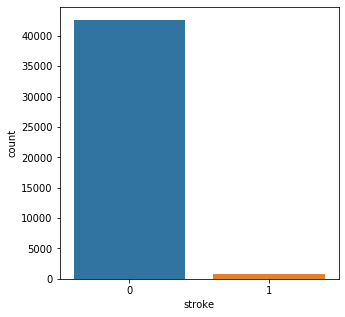

In [6]:
plt.figure(figsize=(5,5))
sns.countplot(x='stroke',data=df)
save('/building_ann/stroke_countplot.png')

In [7]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


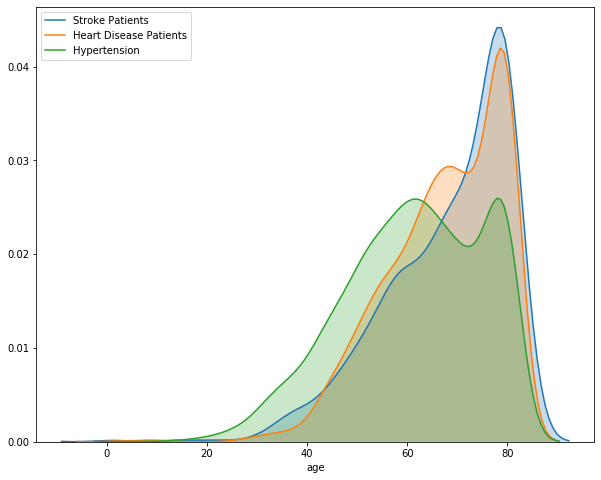

In [8]:
plt.figure(figsize=(10,8))
sns.distplot(df.loc[df['stroke'] == 1]['age'], label='Stroke Patients', kde_kws={"shade": True},hist=False, bins =20)
sns.distplot(df.loc[df['heart_disease'] == 1]['age'], label='Heart Disease Patients', kde_kws={"shade": True},hist=False, bins =20)
sns.distplot(df.loc[df['hypertension'] == 1]['age'], label='Hypertension', kde_kws={"shade": True},hist=False, bins =20)
plt.legend()
save('/building_ann/stroke_age_distplot.png')

In [9]:
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [10]:
df.iloc[95]


gender                          Male
age                               34
hypertension                       0
heart_disease                      1
ever_married                     Yes
work_type                    Private
Residence_type                 Urban
avg_glucose_level             106.23
bmi                              NaN
smoking_status       formerly smoked
stroke                             0
Name: 95, dtype: object

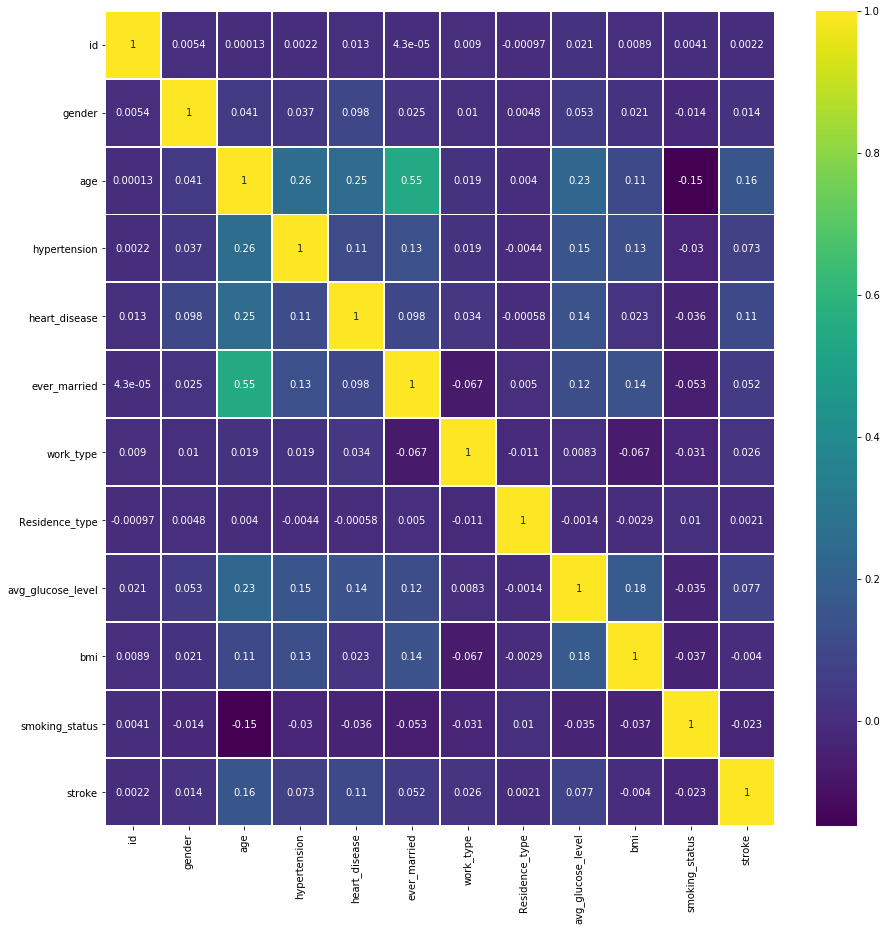

In [11]:
from sklearn import preprocessing
df_hm = loadDataSet()
le = preprocessing.LabelEncoder()
df_hm.gender = le.fit_transform(df_hm.gender)
df_hm.ever_married = le.fit_transform(df_hm.ever_married)
df_hm=df_hm.dropna(subset=['smoking_status'])
df_hm.smoking_status = le.fit_transform(df_hm.smoking_status)
df_hm.Residence_type = le.fit_transform(df_hm.Residence_type)
df_hm.work_type = le.fit_transform(df_hm.work_type)


plt.figure(figsize=(15,15))
sns.heatmap(df_hm.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(12, 0)
save('/building_ann/heatmap.png')

In [12]:
df_hm

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,1,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,52800,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,41413,0,75.0,0,1,1,3,0,243.53,27.0,1,0
8,15266,0,32.0,0,0,1,2,0,77.67,32.3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,0,10.0,0,0,0,4,1,58.64,20.4,1,0
43396,5450,0,56.0,0,0,1,0,1,213.61,55.4,0,0
43397,28375,0,82.0,1,0,1,2,1,91.94,28.9,0,0
43398,27973,1,40.0,0,0,1,2,1,99.16,33.2,1,0


In [13]:
# plt.figure(figsize=(25,25))
# sns.pairplot(df_hm)
# save('/building_ann/pairplot.png')

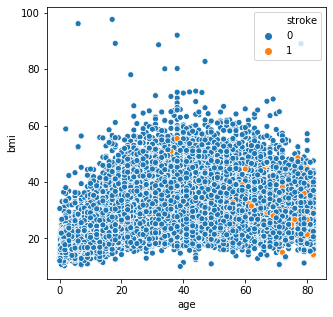

In [14]:
plt.figure(figsize=(5,5))
sns.scatterplot(x='age',y='bmi', hue='stroke', data=df)
save('/building_ann/age_bmi_scatterplot.png')

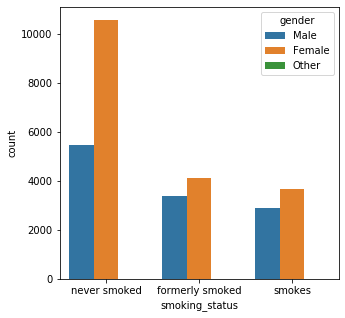

In [15]:
plt.figure(figsize=(5,5))
df = loadDataSet()
sns.countplot(x='smoking_status',data=df,hue='gender')
save('/building_ann/smoking_scatterplot.png')

In [16]:
len(df[df['stroke'] == 1 ])/len(df)

0.01804147465437788

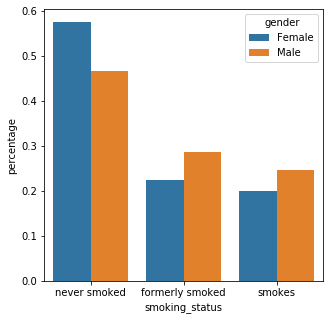

In [17]:
# Adapted code from: https://github.com/mwaskom/seaborn/issues/1027
plt.figure(figsize=(5,5))
df = loadDataSet()
genderOther = df[ df['gender'] == 'Other' ].index
df.drop(genderOther , inplace=True)
x, y, hue = "smoking_status", "percentage", "gender"
# hue_order = ["Male", "Female"]

#f, axes = plt.subplots(1, 2)
# sns.countplot(x=x, hue=hue, data=df, ax=axes[0])
prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df)#, ax=axes[1])
save('/building_ann/gender_smoking_percentage.png')

In [18]:

stroke_y = df[df['stroke'] == 1 ].groupby("smoking_status").count()['stroke']
stroke_n = df[df['stroke'] == 0 ].groupby("smoking_status").count()['stroke']
print(stroke_y/(stroke_y + stroke_n))

smoking_status
formerly smoked    0.029518
never smoked       0.017694
smokes             0.020271
Name: stroke, dtype: float64


In [19]:
df.groupby("smoking_status")['stroke'].value_counts(normalize=True)

smoking_status   stroke
formerly smoked  0         0.970482
                 1         0.029518
never smoked     0         0.982306
                 1         0.017694
smokes           0         0.979729
                 1         0.020271
Name: stroke, dtype: float64

In [20]:
np.bincount(df.apply(lambda x : 1 if x['gender']=='Male' else 0, axis =1))

array([25665, 17724], dtype=int64)

In [21]:
np.bincount(df['stroke'])

array([42606,   783], dtype=int64)

# Missing Data

In [22]:
df.isnull().sum()/len(df)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.033603
smoking_status       0.306299
stroke               0.000000
dtype: float64

In [23]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [24]:
def fill_smoking_status(smoking_status, work_type, gender, age):
    if not pd.isnull(smoking_status):
        return smoking_status
    if work_type=='children' or gender =='Female' or age<18:
        return 'never smoked'
    return 'smokes'
df = loadDataSet()
df['smoking_status'] = df.apply(lambda x : fill_smoking_status(x['smoking_status'], x['work_type'], x['gender'], x['age']), axis=1)
smoking_dummies = pd.get_dummies(df['smoking_status'],drop_first=True)
df = pd.concat([df.drop('smoking_status',axis=1),smoking_dummies],axis=1)

df['gender'] = df['gender'].replace(["Other"], "Male")
gender_dummies = pd.get_dummies(df['gender'],drop_first=True)
df = pd.concat([df.drop('gender',axis=1),gender_dummies],axis=1)

bmi_avg= df.groupby('work_type').mean()['bmi']
df['bmi'] = df.apply(lambda x : bmi_avg[x['work_type']] if np.isnan(x['bmi']) else x['bmi'], axis =1)


work_type_dummies = pd.get_dummies(df['work_type'],drop_first=True)
df = pd.concat([df.drop('work_type',axis=1),work_type_dummies],axis=1)

married_dummies = pd.get_dummies(df['ever_married'],drop_first=True)
df = pd.concat([df.drop('ever_married',axis=1),married_dummies],axis=1)
df = df.rename(columns={'Yes': 'Married'})

residence_dummies = pd.get_dummies(df['Residence_type'],drop_first=True)
df = pd.concat([df.drop('Residence_type',axis=1),residence_dummies],axis=1)

df = df.drop('id',axis=1)


df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,never smoked,smokes,Male,Never_worked,Private,Self-employed,children,Married,Urban
0,3.0,0,0,95.12,18.0,0,1,0,1,0,0,0,1,0,0
1,58.0,1,0,87.96,39.2,0,1,0,1,0,1,0,0,1,1
2,8.0,0,0,110.89,17.6,0,1,0,0,0,1,0,0,0,1
3,70.0,0,0,69.04,35.9,0,0,0,0,0,1,0,0,1,0
4,14.0,0,0,161.28,19.1,0,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,10.0,0,0,58.64,20.4,0,1,0,0,0,0,0,1,0,1
43396,56.0,0,0,213.61,55.4,0,0,0,0,0,0,0,0,1,1
43397,82.0,1,0,91.94,28.9,0,0,0,0,0,1,0,0,1,1
43398,40.0,0,0,99.16,33.2,0,1,0,1,0,1,0,0,1,1


In [25]:
# def fill_smoking_status(smoking_status, work_type, gender, age):
#     if not pd.isnull(smoking_status):
#         return smoking_status
#     if work_type=='children' or gender =='Female' or age<18:
#         return 'never smoked'
#     return 'smokes'

# df = loadDataSet()
# df = df.drop('smoking_status',axis=1)
# df = df.dropna(subset=['bmi'])
# df = df.drop('bmi',axis=1)
# df = df.drop('gender',axis=1)
# df = df.drop('work_type',axis=1)
# df = df.drop('ever_married',axis=1)
# df = df.drop('Residence_type',axis=1)
# # df['smoking_status'] = df.apply(lambda x : fill_smoking_status(x['smoking_status'], x['work_type'], x['gender'], x['age']), axis=1)
# # smoking_dummies = pd.get_dummies(df['smoking_status'],drop_first=True)
# # df = pd.concat([df.drop('smoking_status',axis=1),smoking_dummies],axis=1)

# # df['gender'] = df['gender'].replace(["Other"], "Male")
# # gender_dummies = pd.get_dummies(df['gender'],drop_first=True)
# # df = pd.concat([df.drop('gender',axis=1),gender_dummies],axis=1)



# df = df.drop('id',axis=1)


# df

In [26]:

df.isnull().sum()

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
stroke               0
never smoked         0
smokes               0
Male                 0
Never_worked         0
Private              0
Self-employed        0
children             0
Married              0
Urban                0
dtype: int64

In [27]:
# # sorted(df['smoking_status'].unique())
# plt.figure(figsize=(10,10))
# sns.countplot(x='stroke',data=df,hue='smoking_status')

In [28]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,never smoked,smokes,Male,Never_worked,Private,Self-employed,children,Married,Urban
age,1.000000,0.272169,0.250188,0.237627,0.359555,0.156049,-0.289450,0.118157,-0.027768,-0.069509,0.143657,0.326913,-0.641240,0.693070,0.001299
hypertension,0.272169,1.000000,0.119777,0.160211,0.158361,0.075332,-0.073422,0.021051,0.023902,-0.019319,0.007236,0.100243,-0.130171,0.176575,-0.003124
heart_disease,0.250188,0.119777,1.000000,0.146938,0.058548,0.113763,-0.111078,0.054971,0.082270,-0.014292,-0.006327,0.099342,-0.089559,0.128833,-0.002743
avg_glucose_level,0.237627,0.160211,0.146938,1.000000,0.188248,0.078917,-0.081701,0.027844,0.035695,-0.014516,0.008048,0.080246,-0.114174,0.153607,0.000014
bmi,0.359555,0.158361,0.058548,0.188248,1.000000,0.022308,-0.175925,0.096763,-0.020754,-0.021918,0.203401,0.084054,-0.462608,0.342836,-0.003619
stroke,0.156049,0.075332,0.113763,0.078917,0.022308,1.000000,-0.043833,0.015820,0.011281,-0.008674,-0.002464,0.061195,-0.054115,0.071920,0.002247
never smoked,-0.289450,-0.073422,-0.111078,-0.081701,-0.175925,-0.043833,1.000000,-0.658491,-0.210051,0.033258,-0.128436,-0.082699,0.309063,-0.242106,-0.000919
smokes,0.118157,0.021051,0.054971,0.027844,0.096763,0.015820,-0.658491,1.000000,0.212961,-0.020449,0.113459,0.022885,-0.212152,0.128735,0.005024
Male,-0.027768,0.023902,0.082270,0.035695,-0.020754,0.011281,-0.210051,0.212961,1.000000,0.002700,-0.052028,-0.002953,0.089127,-0.031183,0.001558
Never_worked,-0.069509,-0.019319,-0.014292,-0.014516,-0.021918,-0.008674,0.033258,-0.020449,0.002700,1.000000,-0.074011,-0.027566,-0.026017,-0.080734,0.003089


## Split Data

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = df.drop('stroke', axis =1).values
y = df['stroke'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [31]:
help(table)

Help on function table in module pandas.plotting._misc:

table(ax, data, rowLabels=None, colLabels=None, **kwargs)
    Helper function to convert DataFrame and Series to matplotlib.table.
    
    Parameters
    ----------
    ax : Matplotlib axes object
    data : DataFrame or Series
        Data for table contents.
    **kwargs
        Keyword arguments to be passed to matplotlib.table.table.
        If `rowLabels` or `colLabels` is not specified, data index or column
        name will be used.
    
    Returns
    -------
    matplotlib table object



# Train the Model

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def save_report_to_latex(model_name, report):
    df_latex = pd.DataFrame(report).transpose()
#     ax = plt.subplot(441, frame_on=False)
#     ax.xaxis.set_visible(False)  # hide the x axis
#     ax.yaxis.set_visible(False)  
#     table(ax, data=df_latex)
#     plt.savefig('../../images/building_ann/cr_' + model_name + '.png')
    
    with open('../../images/building_ann/' + model_name + '.tex','w') as tf:
        tf.write(df_latex.to_latex())
    return

# part of this code is inspired from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data


def plot_model_results(model_name, model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
    save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(model.history.history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
    save('/building_ann/' + model_name + '.png')
    plt.show()



In [34]:
help(table)

Help on function table in module pandas.plotting._misc:

table(ax, data, rowLabels=None, colLabels=None, **kwargs)
    Helper function to convert DataFrame and Series to matplotlib.table.
    
    Parameters
    ----------
    ax : Matplotlib axes object
    data : DataFrame or Series
        Data for table contents.
    **kwargs
        Keyword arguments to be passed to matplotlib.table.table.
        If `rowLabels` or `colLabels` is not specified, data index or column
        name will be used.
    
    Returns
    -------
    matplotlib table object



In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
        f1_m
]

Using TensorFlow backend.


In [36]:
def create_model_logistic(model_name, X_train=X_train, y_train=y_train, with_weigths=True):
    from sklearn.linear_model import LogisticRegression
    
    
    class_weight= {0:1, 1:2}
    if (with_weigths):
        neg, pos = np.bincount(y_train)
        total = neg + pos
        print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        class_weight = {0: weight_for_0, 1: weight_for_1}
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))

    logit = LogisticRegression(C=1, class_weight= class_weight, random_state = 123, solver='saga')
    
    logit.fit(X_train, y_train)
    predictions = logit.predict(X_test)
    print(classification_report(y_test, predictions))
    
    
#     return model.evaluate(X_test, y_test)

Examples:
    Total: 30380
    Positive: 543 (1.79% of total)

Weight for class 0: 0.51
Weight for class 1: 27.97
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30380 samples, validate on 13020 samples
Epoch 1/500
30380/30380 [==============================] - 14s 445us/sample - loss: 0.6177 - accuracy: 0.7757 - val_loss: 0.5349 - val_accuracy: 0.5452
Epoch 2/500
30380/30380 [==============================] - 11s 372us/sample - loss: 0.5380 - accuracy: 0.6654 - val_loss: 0.5029 - val_accuracy: 0.6906
Epoch 3/500
30380/30380 [==============================] - 12s 411us/sample - loss: 0.5123 - accuracy: 0.6938 - val_loss: 0.5116 - val_accuracy: 0.5985
Epoch 4/500
30380/30380 [==============================] - 12s 391us/sample - loss: 0.5020 - accuracy: 0.6962 - val_loss: 0.4978 - val_accuracy: 0.6946
Epoch 5/500
30380/30380 [==============================] - 12s 384us/sample - loss: 0.4953 - accuracy: 0.7064 - val_loss: 0.5081 - val_accuracy: 0.6505
Epoch 6/500
30380/30380 [=

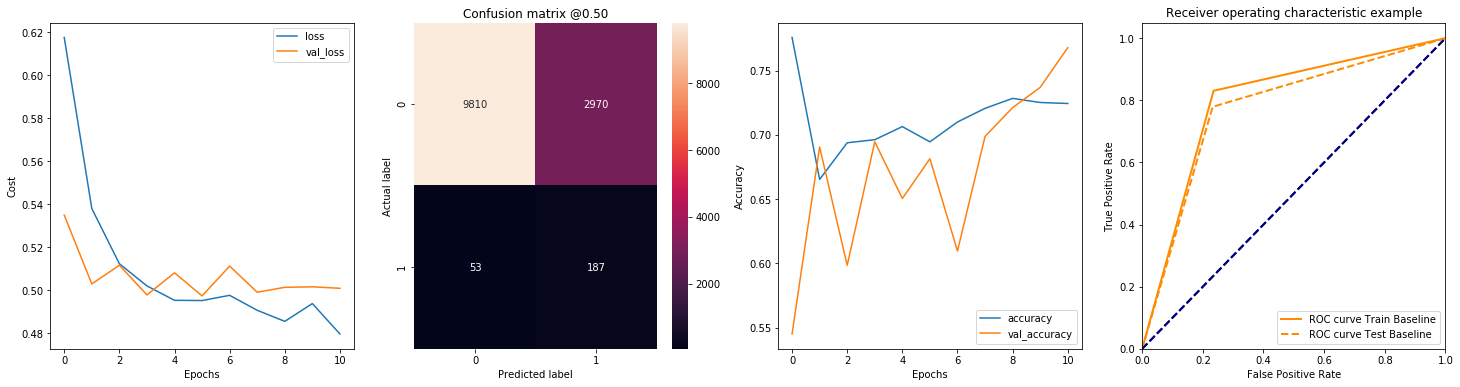

In [126]:
def create_model(model_name, X_train=X_train, y_train=y_train, with_weigths=True):
    model = Sequential()
    model.add(Dense(1024,  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256,  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=1, activation='sigmoid'))
    
    opt = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'] )
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    
    class_weight= {0:1, 1:1}
    if (with_weigths):
        neg, pos = np.bincount(y_train)
        total = neg + pos
        print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        class_weight = {0: weight_for_0, 1: weight_for_1}
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
        
    model.fit(x=X_train, 
              y=y_train, 
              epochs=500,
              class_weight=class_weight,
#               batch_size=250,
              validation_data=(X_test, y_test), 
              verbose=1,
              callbacks = [early_stop]
              )
    
    plot_model_results(model_name,model)
    return model
    
#     return model.evaluate(X_test, y_test)
model = create_model('weighted')
# model.save('weighted-stroke.h5')
# pd.DataFrame.from_dict(model.history.history).to_csv('weighted-stroke.csv',index=False)

Examples:
    Total: 30380
    Positive: 543 (1.79% of total)

Weight for class 0: 0.51
Weight for class 1: 27.97
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30380 samples, validate on 13020 samples
Epoch 1/500
30380/30380 [==============================] - 2s 72us/sample - loss: 1.7773 - accuracy: 0.6353 - val_loss: 2.6906 - val_accuracy: 0.0000e+00
Epoch 2/500
30380/30380 [==============================] - 1s 33us/sample - loss: 2934.2836 - accuracy: 0.5071 - val_loss: 94.8366 - val_accuracy: 0.0034
Epoch 3/500
30380/30380 [==============================] - 1s 33us/sample - loss: 11405.9754 - accuracy: 0.5048 - val_loss: 12093.8625 - val_accuracy: 1.0000
Epoch 4/500
30380/30380 [==============================] - 1s 34us/sample - loss: 43673.3083 - accuracy: 0.5135 - val_loss: 29250.3614 - val_accuracy: 0.0665
Epoch 5/500
30380/30380 [==============================] - 1s 36us/sample - loss: 225947.0889 - accuracy: 0.5063 - val_loss: 1220560.4870 - val_accuracy: 1.0000
E

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12780
           1       0.00      0.00      0.00       240

    accuracy                           0.98     13020
   macro avg       0.49      0.50      0.50     13020
weighted avg       0.96      0.98      0.97     13020



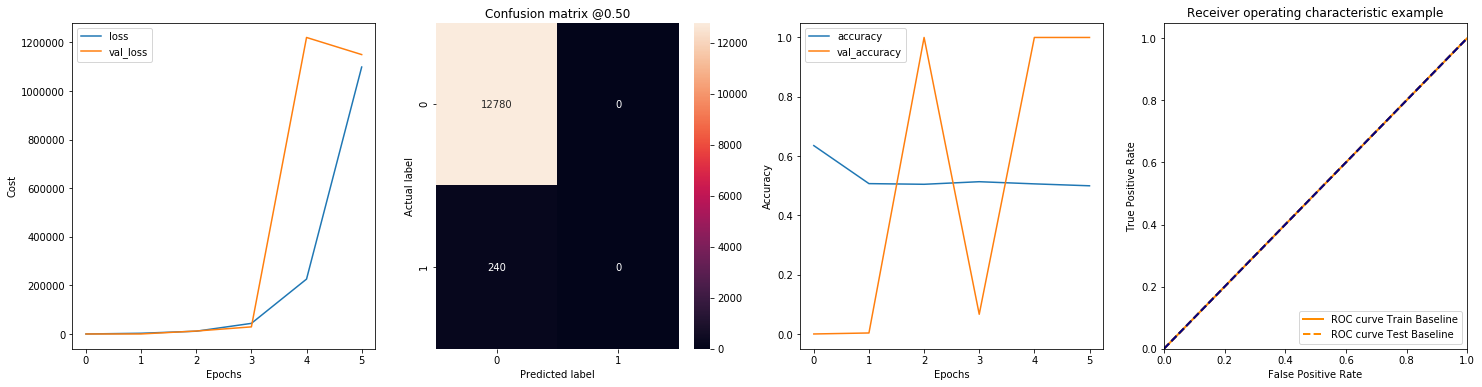

In [39]:
# create_model('simple', with_weigths=False)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0.7057387510889687, 0.7034255601097833, 0.6919146255100143, 0.6825914975939965, 0.6731131732699273, 0.6585660417998912, 0.6285159508204129, 0.6055951713436603, 0.5919021616117824, 0.5935738603875699, 0.5813935124673995, 0.5684382864681806, 0.5587855124744323, 0.572918660404103, 0.5483186866810951, 0.5549426939512571, 0.5462535398866959, 0.5282466294166679, 0.5295522543966495, 0.5384620905432598, 0.5400174425631624, 0.5269652669311277, 0.5106209025248012, 0.5188011805759283, 0.5201975985174512, 0.5235365960033337, 0.5211386683447884, 0.5288999424787475, 0.5206109064927299]


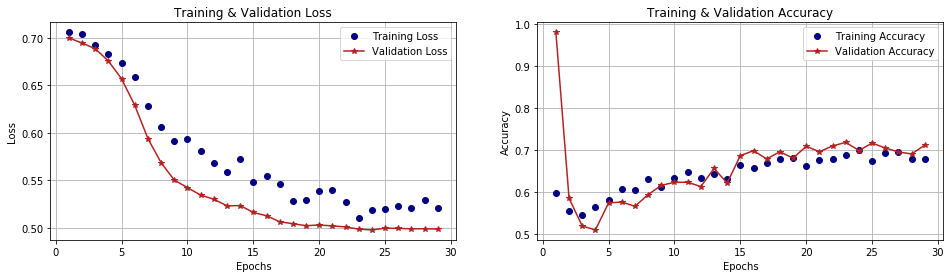

In [40]:
import kr_helper_funcs as kr
import lime
model = tf.keras.models.load_model('weighted-stroke.h5')
history = pd.read_csv("weighted-stroke.csv")
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [41]:
import lime
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_train)

In [42]:
help( lime_tabular.LimeTabularExplainer)

Help on class LimeTabularExplainer in module lime.lime_tabular:

class LimeTabularExplainer(builtins.object)
 |  LimeTabularExplainer(training_data, mode='classification', training_labels=None, feature_names=None, categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, verbose=False, class_names=None, feature_selection='auto', discretize_continuous=True, discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)
 |  
 |  Explains predictions on tabular (i.e. matrix) data.
 |  For numerical features, perturb them by sampling from a Normal(0,1) and
 |  doing the inverse operation of mean-centering and scaling, according to the
 |  means and stds in the training data. For categorical features, perturb by
 |  sampling according to the training distribution, and making a binary
 |  feature that is 1 when the value is the same as the instance being
 |  explained.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, training

In [43]:
exp = explainer.explain_instance(X_test[4], model.predict, num_features=2, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

C:\Users\dan39\Anaconda3\lib\site-packages\lime\lime_tabular.py:377: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  """)


In [97]:
import shap
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict_proba, X_train[1:5], link="logit")


In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance


In [95]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0,:], X_test[0,:],feature_names = list(df.columns)[0:13], link="logit")

AttributeError: 'LimeTabularExplainer' object has no attribute 'expected_value'

In [53]:
help(shap.force_plot)

Help on function force_plot in module shap.plots.force:

force_plot(base_value, shap_values, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, and should be the same shap

In [61]:
help(explainer.shap_values)

Help on method shap_values in module shap.explainers.kernel:

shap_values(X, **kwargs) method of shap.explainers.kernel.KernelExplainer instance
    Estimate the SHAP values for a set of samples.
    
    Parameters
    ----------
    X : numpy.array or pandas.DataFrame or any scipy.sparse matrix
        A matrix of samples (# samples x # features) on which to explain the model's output.
    
    nsamples : "auto" or int
        Number of times to re-evaluate the model when explaining each prediction. More samples
        lead to lower variance estimates of the SHAP values. The "auto" setting uses
        `nsamples = 2 * X.shape[1] + 2048`.
    
    l1_reg : "num_features(int)", "auto" (default for now, but deprecated), "aic", "bic", or float
        The l1 regularization to use for feature selection (the estimation procedure is based on
        a debiased lasso). The auto option currently uses "aic" when less that 20% of the possible sample
        space is enumerated, otherwise it us

In [62]:
model.predict(X_test[5].reshape)

ValueError: Failed to find data adapter that can handle input: <class 'builtin_function_or_method'>, <class 'NoneType'>

In [66]:

exp = explainer.explain_instance(X_test[4], model.predict, num_features=2, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

print(exp.as_map())
help(exp)

{0: [(0, 0.32353602011637295), (11, 0.3125817952622546)]}
Help on Explanation in module lime.explanation object:

class Explanation(builtins.object)
 |  Explanation(domain_mapper, mode='classification', class_names=None, random_state=None)
 |  
 |  Object returned by explainers.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, domain_mapper, mode='classification', class_names=None, random_state=None)
 |      Initializer.
 |      
 |      Args:
 |          domain_mapper: must inherit from DomainMapper class
 |          type: "classification" or "regression"
 |          class_names: list of class names (only used for classification)
 |          random_state: an integer or numpy.RandomState that will be used to
 |              generate random numbers. If None, the random state will be
 |              initialized using the internal numpy seed.
 |  
 |  as_html(self, labels=None, predict_proba=True, show_predicted_value=True, **kwargs)
 |      Returns the explanation as an html page.


In [ ]:
stop !pip install lime -U

[29837   543]
[29837 29837]
Examples:
    Total: 59674
    Positive: 29837 (50.00% of total)

Weight for class 0: 1.00
Weight for class 1: 1.00
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 59674 samples, validate on 13020 samples
Epoch 1/500
59674/59674 [==============================] - 23s 388us/sample - loss: 0.4889 - accuracy: 0.7683 - val_loss: 0.5182 - val_accuracy: 0.6919
Epoch 2/500
59674/59674 [==============================] - 20s 335us/sample - loss: 0.4273 - accuracy: 0.8110 - val_loss: 0.3945 - val_accuracy: 0.7725
Epoch 3/500
59674/59674 [==============================] - 20s 340us/sample - loss: 0.4056 - accuracy: 0.8216 - val_loss: 0.4212 - val_accuracy: 0.7763
Epoch 4/500
59674/59674 [==============================] - 21s 344us/sample - loss: 0.3908 - accuracy: 0.8276 - val_loss: 0.3904 - val_accuracy: 0.7869
Epoch 5/500
59674/59674 [==============================] - 20s 332us/sample - loss: 0.3795 - accuracy: 0.8323 - val_loss: 0.4699 - val_accuracy: 0.7

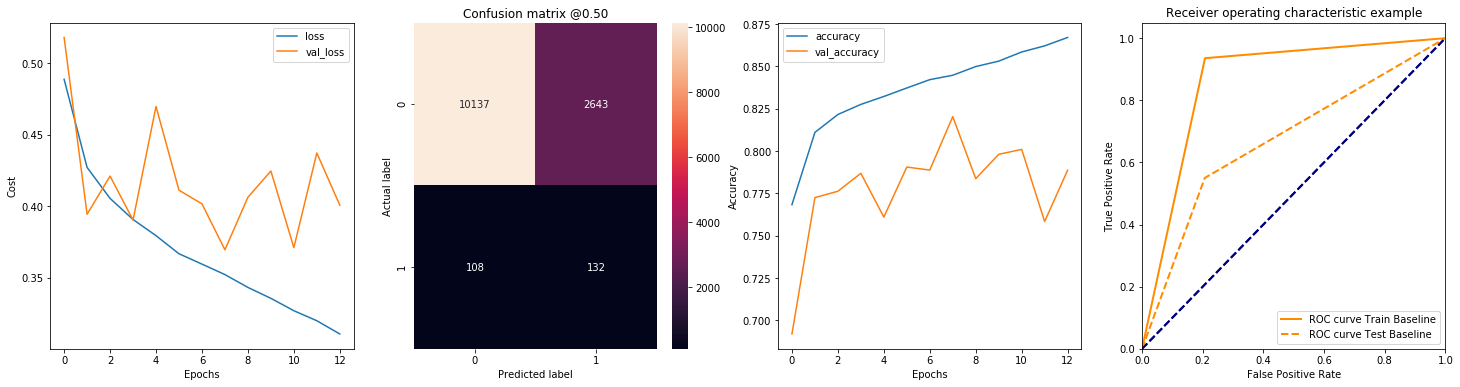

In [128]:
print(np.bincount(y_train))
smt = SMOTE()
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_SMOTE))
create_model('smote',X_train_SMOTE,y_train_SMOTE)

In [ ]:
# print(np.bincount(y_train))
# nr = NearMiss()
# X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train)
# print(np.bincount(y_train_miss))
# create_model('near_miss',X_train_miss,y_train_miss)

In [ ]:
# print(np.bincount(y_train))
# cluster = ClusterCentroids()
# X_train_cluster, y_train_cluster = cluster.fit_sample(X_train, y_train)
# print(np.bincount(y_train_cluster))
# create_model('cluster', X_train_cluster, y_train_cluster)

[29837   543]
[29560 29560]
Examples:
    Total: 59120
    Positive: 29560 (50.00% of total)

Weight for class 0: 1.00
Weight for class 1: 1.00
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 59120 samples, validate on 13020 samples
Epoch 1/500
59120/59120 [==============================] - 23s 382us/sample - loss: 0.4834 - accuracy: 0.7722 - val_loss: 0.4283 - val_accuracy: 0.7455
Epoch 2/500
59120/59120 [==============================] - 21s 348us/sample - loss: 0.4183 - accuracy: 0.8188 - val_loss: 0.3562 - val_accuracy: 0.8082
Epoch 3/500
59120/59120 [==============================] - 21s 347us/sample - loss: 0.3973 - accuracy: 0.8274 - val_loss: 0.4292 - val_accuracy: 0.7634
Epoch 4/500
59120/59120 [==============================] - 21s 351us/sample - loss: 0.3822 - accuracy: 0.8343 - val_loss: 0.3698 - val_accuracy: 0.8039
Epoch 5/500
59120/59120 [==============================] - 21s 364us/sample - loss: 0.3699 - accuracy: 0.8397 - val_loss: 0.3834 - val_accuracy: 0.8

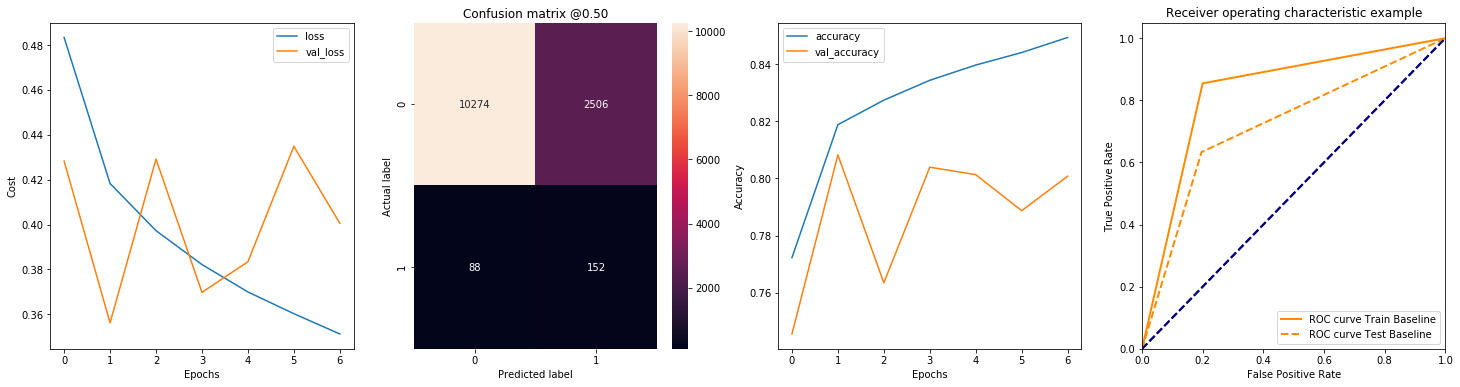

In [127]:
print(np.bincount(y_train))
smt = SMOTETomek('auto')
X_train_SMTomek, y_train_SMTomek = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_SMTomek))
create_model('SMOTETomek', X_train_SMTomek, y_train_SMTomek)

In [ ]:
# print(np.bincount(y_train))
# rus = RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)
# print(np.bincount(y_train_rus))
# model = create_model('rus', X_train_rus, y_train_rus)

In [ ]:
print(np.bincount(y_train))
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
print(np.bincount(y_train_ros))
create_model('ros', X_train_ros, y_train_ros)

In [ ]:
print(np.bincount(y_train))
smte = SMOTEENN('auto')
X_train_smte, y_train_smte = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_smte))
create_model('smte', X_train_smte, y_train_smte)

In [ ]:
hyparam 

In [ ]:
from tensorboard.plugins.hparams import api as hp
import os
HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([32, 49, 79]))
HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([32, 16,8]))
HP_NUM_UNITS_L3 = hp.HParam('num_units_l3', hp.Discrete([8,4]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([250,1000]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LOSS = hp.HParam('loss', hp.Discrete(['mse', 'binary_crossentropy']))

# HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([16]))
# HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([4]))
# HP_NUM_UNITS_L3 = hp.HParam('num_units_l3', hp.Discrete([3]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
# HP_LOSS = hp.HParam('loss', hp.Discrete(['binary_crossentropy']))

# print('Deleting previous logs')
# !del -f "logs\\"
# print('Delet previous logs')




# base_dir = 'logs\\hparam_tuning\\' + datetime.now().strftime("%Y-%m-%d-%H%M") + '\\'
base_dir = os.path.join('logs', 'hparam_tuning', datetime.now().strftime("%Y-%m-%d-%H%M"))
if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        

def train_test_model(model_name, hparams, logdir, X_train=X_train, y_train=y_train, with_weigths=True):
    model = Sequential()
    model.add(Dense(hparams[HP_NUM_UNITS_L1],  activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(hparams[HP_NUM_UNITS_L2],  activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(hparams[HP_NUM_UNITS_L3], activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(units=1,activation='sigmoid'))

    model.compile(loss=hparams[HP_LOSS], optimizer=hparams[HP_OPTIMIZER],  metrics=METRICS )
    
    class_weight= {0:1, 1:1}
    if (with_weigths):
        neg, pos = np.bincount(y_train)
        total = neg + pos
        print('Examples: Total: {} Positive: {} ({:.2f}% of total)'.format(
        total, pos, 100 * pos / total))
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        class_weight = {0: weight_for_0, 1: weight_for_1}
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    
    model.fit(x=X_train, 
              y=y_train, 
              epochs=500,
              class_weight=class_weight,
              batch_size=hparams[HP_BATCH_SIZE],
              validation_data=(X_test, y_test), 
              verbose=0,
              callbacks = [EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30), 
                           tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=False,
                                                          write_images=False, update_freq='epoch', 
                                                          profile_batch = 100000000),  # log metrics
                           hp.KerasCallback(logdir, hparams)]
              )
    
#     plot_model_results(model_name,model)
    
    
    results = model.evaluate(X_test, y_test)
    print(results)
    return results

def run(run_name, hparams,  X_train=X_train, y_train=y_train):
    log_dir= os.path.join(base_dir, run_name)
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        results = train_test_model(run_name, hparams, log_dir, X_train, y_train)
        tf.summary.scalar('loss', results[0], step=1)
        tf.summary.scalar('tp', results[1], step=1)
        tf.summary.scalar('fp', results[2], step=1)
        tf.summary.scalar('tn', results[3], step=1)
        tf.summary.scalar('fn', results[4], step=1)
        tf.summary.scalar('accuracy', results[5], step=1)
        tf.summary.scalar('precision', results[6], step=1)
        tf.summary.scalar('recall', results[7], step=1)
        tf.summary.scalar('auc', results[8], step=1)
        tf.summary.scalar('f1-score', results[9], step=1)
                                     
def hrun(dataset_name='default', X_train=X_train, y_train=y_train):
    session_num=0
    for num_units_l1 in HP_NUM_UNITS_L1.domain.values:
        for num_units_l2 in HP_NUM_UNITS_L2.domain.values:
            for num_units_l3 in HP_NUM_UNITS_L3.domain.values:
                for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                    for optimizer in HP_OPTIMIZER.domain.values:
                        for loss in HP_LOSS.domain.values:
                            for batch_size in HP_BATCH_SIZE.domain.values:
                                hparams = {
                                  HP_NUM_UNITS_L1: num_units_l1,
                                  HP_NUM_UNITS_L2: num_units_l2,
                                  HP_NUM_UNITS_L3: num_units_l3,
                                  HP_DROPOUT: dropout_rate,
                                  HP_OPTIMIZER: optimizer,
                                  HP_LOSS: loss,
                                  HP_BATCH_SIZE: batch_size}
                                run_name =dataset_name + "-run-%d" % session_num
                                print('\n--- ----------Starting trial:',  run_name, '--------------------------')
                                print({h.name: hparams[h] for h in hparams})
                                run(run_name, hparams,  X_train, y_train)
                                session_num += 1

In [ ]:
print(np.bincount(y_train))
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
print(np.bincount(y_train_ros))
create_model('ros', X_train_ros, y_train_ros)

In [ ]:
print(np.bincount(y_train))
smte = SMOTEENN('auto')
X_train_smte, y_train_smte = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train_smte))
create_model('smte', X_train_smte, y_train_smte)

In [ ]:
stop

In [ ]:
from tensorboard.plugins.hparams import api as hp
import os
HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([32, 49, 79]))
HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([32, 16,8]))
HP_NUM_UNITS_L3 = hp.HParam('num_units_l3', hp.Discrete([8,4]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([250,1000]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_LOSS = hp.HParam('loss', hp.Discrete(['mse', 'binary_crossentropy']))

# HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([16]))
# HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([4]))
# HP_NUM_UNITS_L3 = hp.HParam('num_units_l3', hp.Discrete([3]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
# HP_LOSS = hp.HParam('loss', hp.Discrete(['binary_crossentropy']))

# print('Deleting previous logs')
# !del -f "logs\\"
# print('Delet previous logs')




# base_dir = 'logs\\hparam_tuning\\' + datetime.now().strftime("%Y-%m-%d-%H%M") + '\\'
base_dir = os.path.join('logs', 'hparam_tuning', datetime.now().strftime("%Y-%m-%d-%H%M"))
if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        

def train_test_model(model_name, hparams, logdir, X_train=X_train, y_train=y_train, with_weigths=True):
    model = Sequential()
    model.add(Dense(hparams[HP_NUM_UNITS_L1],  activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(hparams[HP_NUM_UNITS_L2],  activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(hparams[HP_NUM_UNITS_L3], activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(units=1,activation='sigmoid'))

    model.compile(loss=hparams[HP_LOSS], optimizer=hparams[HP_OPTIMIZER],  metrics=METRICS )
    
    class_weight= {0:1, 1:1}
    if (with_weigths):
        neg, pos = np.bincount(y_train)
        total = neg + pos
        print('Examples: Total: {} Positive: {} ({:.2f}% of total)'.format(
        total, pos, 100 * pos / total))
        weight_for_0 = (1 / neg)*(total)/2.0 
        weight_for_1 = (1 / pos)*(total)/2.0
        class_weight = {0: weight_for_0, 1: weight_for_1}
        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    
    model.fit(x=X_train, 
              y=y_train, 
              epochs=500,
              class_weight=class_weight,
              batch_size=hparams[HP_BATCH_SIZE],
              validation_data=(X_test, y_test), 
              verbose=0,
              callbacks = [EarlyStopping(monitor='loss', mode='min', verbose=1, patience=30), 
                           tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=False,
                                                          write_images=False, update_freq='epoch', 
                                                          profile_batch = 100000000),  # log metrics
                           hp.KerasCallback(logdir, hparams)]
              )
    
#     plot_model_results(model_name,model)
    
    
    results = model.evaluate(X_test, y_test)
    print(results)
    return results

def run(run_name, hparams,  X_train=X_train, y_train=y_train):
    log_dir= os.path.join(base_dir, run_name)
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        results = train_test_model(run_name, hparams, log_dir, X_train, y_train)
        tf.summary.scalar('loss', results[0], step=1)
        tf.summary.scalar('tp', results[1], step=1)
        tf.summary.scalar('fp', results[2], step=1)
        tf.summary.scalar('tn', results[3], step=1)
        tf.summary.scalar('fn', results[4], step=1)
        tf.summary.scalar('accuracy', results[5], step=1)
        tf.summary.scalar('precision', results[6], step=1)
        tf.summary.scalar('recall', results[7], step=1)
        tf.summary.scalar('auc', results[8], step=1)
        tf.summary.scalar('f1-score', results[9], step=1)
                                     
def hrun(dataset_name='default', X_train=X_train, y_train=y_train):
    session_num=0
    for num_units_l1 in HP_NUM_UNITS_L1.domain.values:
        for num_units_l2 in HP_NUM_UNITS_L2.domain.values:
            for num_units_l3 in HP_NUM_UNITS_L3.domain.values:
                for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                    for optimizer in HP_OPTIMIZER.domain.values:
                        for loss in HP_LOSS.domain.values:
                            for batch_size in HP_BATCH_SIZE.domain.values:
                                hparams = {
                                  HP_NUM_UNITS_L1: num_units_l1,
                                  HP_NUM_UNITS_L2: num_units_l2,
                                  HP_NUM_UNITS_L3: num_units_l3,
                                  HP_DROPOUT: dropout_rate,
                                  HP_OPTIMIZER: optimizer,
                                  HP_LOSS: loss,
                                  HP_BATCH_SIZE: batch_size}
                                run_name =dataset_name + "-run-%d" % session_num
                                print('\n--- ----------Starting trial:',  run_name, '--------------------------')
                                print({h.name: hparams[h] for h in hparams})
                                run(run_name, hparams,  X_train, y_train)
                                session_num += 1

In [ ]:
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# %tensorboard --logdir=./logs

In [ ]:
generated_datasets_X={}
generated_datasets_y={}

generated_datasets_X['weighted'] = X_train
generated_datasets_y['weighted'] = y_train

generated_datasets_X['smote'] = X_train_SMOTE
generated_datasets_y['smote'] = y_train_SMOTE

generated_datasets_X['smte'] = X_train_smte
generated_datasets_y['smte'] = y_train_smte

generated_datasets_X['SMOTETomek'] = X_train_SMTomek
generated_datasets_y['SMOTETomek'] = y_train_SMTomek

generated_datasets_X['ros'] = X_train_ros
generated_datasets_y['ros'] = y_train_ros

generated_datasets_X['rus'] = X_train_rus
generated_datasets_y['rus'] = y_train_rus

for key in generated_datasets_X.keys():
    print('Running dataset:' + key)
    hrun(key,generated_datasets_X.get(key), generated_datasets_y.get(key))

In [ ]:
from multiprocessing import Pool
p = Pool()
p.map(hrun, [(key,generated_datasets_X.get(key), generated_datasets_y.get(key)) for key in generated_datasets_X.keys()])
# results = p.map(lambda x: x**2, [1 for key in [1,2,3]])

In [ ]:
datetime.now()

In [ ]:
tf.Session(config=tf.ConfigProto(
  intra_op_parallelism_threads=NUM_THREADS))

In [ ]:
a = os.path.join('logs', 'hparam_tuning', datetime.now().strftime("%Y-%m-%d-%H%M"))
b = os.path.join(a, 'b')
b

In [ ]:
help(tensorboard)

In [ ]:
roc_curve(y_test,predictions)

In [ ]:
len(predictions)

In [68]:
row = 200
patient = df.drop('stroke', axis = 1).iloc[row]
patient = scaler.transform(patient.values.reshape(1,14))
patient

array([[0.25537109, 0.        , 0.        , 0.04685647, 0.20342857,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ]])

In [ ]:
np.append(model.predict_proba(patient)[0], 1-model.predict_proba(patient)[0][0])

In [ ]:
def predict_proba_softmax(x):
    prediction = model.predict_proba(x)
    prediction[0] = np.append(prediction[0], 1-prediction[0][0])
    return prediction

In [ ]:
predict_proba_softmax(patient)

In [71]:
for row in range (0,10):
    patient = df.drop('stroke', axis = 1).iloc[row]
    patient = scaler.transform(patient.values.reshape(1,14))
    prediction = (model.predict_classes(patient))[0][0]
    print ("Predicted:{} Actual:{}".format(prediction,df.iloc[row]['stroke']))

Predicted:0 Actual:0.0
Predicted:1 Actual:0.0
Predicted:0 Actual:0.0
Predicted:1 Actual:0.0
Predicted:0 Actual:0.0
Predicted:0 Actual:0.0
Predicted:0 Actual:0.0
Predicted:1 Actual:0.0
Predicted:0 Actual:0.0
Predicted:1 Actual:0.0


In [73]:
print(model.predict_proba(patient))

[[0.776198]]


In [ ]:
help(explainer.explain_instance)

In [ ]:
help(lime.lime_tabular.LimeTabularExplainer)

In [ ]:
import lime
from lime import lime_tabular

feature_names = df.drop('stroke', axis = 1).columns
explainer = lime_tabular.LimeTabularExplainer(X_train,training_labels=[0,1], feature_names=feature_names)
# explainer = lime.lime_tabular.LimeTabularExplainer(X_train_rus ,feature_names = df.columns, kernel_width=3)
predict_fn = lambda x: model.predict_proba(x).astype(float)
exp = explainer.explain_instance(patient[0], predict_fn, labels=['stroke'], top_labels=2, num_features=5)
exp.show_in_notebook(show_all=True)

In [ ]:
model.predict_proba(patient).astype(float)

In [ ]:
patient[0]

In [ ]:
df.drop('stroke', axis = 1).iloc[row]

In [ ]:
df.drop('stroke', axis = 1).columns

In [74]:

help(np.append)

Help on function append in module numpy:

append(arr, values, axis=None)
    Append values to the end of an array.
    
    Parameters
    ----------
    arr : array_like
        Values are appended to a copy of this array.
    values : array_like
        These values are appended to a copy of `arr`.  It must be of the
        correct shape (the same shape as `arr`, excluding `axis`).  If
        `axis` is not specified, `values` can be any shape and will be
        flattened before use.
    axis : int, optional
        The axis along which `values` are appended.  If `axis` is not
        given, both `arr` and `values` are flattened before use.
    
    Returns
    -------
    append : ndarray
        A copy of `arr` with `values` appended to `axis`.  Note that
        `append` does not occur in-place: a new array is allocated and
        filled.  If `axis` is None, `out` is a flattened array.
    
    See Also
    --------
    insert : Insert elements into an array.
    delete : Delet

In [ ]:
import lime
from lime import lime_tabular

def predict_patient(row):
    print (df.iloc[row])
    patient = df.drop('stroke', axis = 1).iloc[row]
    patient = scaler.transform(patient.values.reshape(1,14))
    print(patient[0])
    prediction = (model.predict_classes(patient))[0][0]
    probability =(model.predict(patient))[0][0]
    print ("Probability: {} Predicted:{} Actual:{}".format(probability, prediction,df.iloc[row]['stroke']))



def explain_patient(row):
    explainer = lime_tabular.LimeTabularExplainer(X_train)
    exp = explainer.explain_instance(X_test[4], model.predict, num_features=2, 
                                     labels={0:'healthy', 1:'stroke'}, top_labels=10)
    exp.show_in_notebook(show_table=True, show_all=False)
    return exp.as_map()

row = 20
predict_patient(row)
explain_patient(row)

print (df.iloc[row])
print ([row])

In [ ]:
df.iloc[row]

In [86]:
help(explainer.explain_instance)

Help on method explain_instance in module lime.lime_tabular:

explain_instance(data_row, predict_fn, labels=(1,), top_labels=None, num_features=10, num_samples=5000, distance_metric='euclidean', model_regressor=None) method of lime.lime_tabular.LimeTabularExplainer instance
    Generates explanations for a prediction.
    
    First, we generate neighborhood data by randomly perturbing features
    from the instance (see __data_inverse). We then learn locally weighted
    linear models on this neighborhood data to explain each of the classes
    in an interpretable way (see lime_base.py).
    
    Args:
        data_row: 1d numpy array or scipy.sparse matrix, corresponding to a row
        predict_fn: prediction function. For classifiers, this should be a
            function that takes a numpy array and outputs prediction
            probabilities. For regressors, this takes a numpy array and
            returns the predictions. For ScikitClassifiers, this is
            `classifier.p